# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Handling Missing Values](#handling-missing-values)
3. [Feature Distributions](#feature-distributions)
4. [Possible Biases](#possible-biases)
5. [Correlations](#correlations)


## Initial Setup

In [2]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# setting default number of rows and columns to be displayed
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_colwidth', None)  # No limit on column width

In [5]:
# number formatting for better readability

nf_0 = lambda x: f'{x:,.0f}' if isinstance(x, (int, float)) else x # rounding-off to 0 decimals with thousand separator (for integers)
nf_2 = lambda x: f'{x:,.2f}' if isinstance(x, (int, float)) else x # rounding-off to 2 decimals with thousand separator (for floats)
nf_2np = lambda x: f'{x:.2%}' if isinstance(x, (int, float)) else x # rounding-off to 2 decimals with percent sign, assuming the number is calculated as percentage and not displayed as percentage
nf_2pp = lambda x: f'{x/100:.2%}' if isinstance(x, (int, float)) else x # rounding-off to 2 decimals with percent sign, assuming the number is displayed as percentage but without percentage sign

In [6]:
# adjusting CSS for the Jupyter Notebook, to avoid text-wrapping
from IPython.display import display, HTML

display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

## Dataset Overview

[Provide a high-level overview of the dataset. This should include the source of the dataset, the number of samples, the number of features, and example showing the structure of the dataset.]


In [7]:
# loading the dataset
df = pd.read_csv('https://raw.githubusercontent.com/kalakhushi18/Advance-Time-Series-Prediction-W24/refs/heads/main/dataset.csv')
# Number of samples
num_samples = df.shape[0]

# Number of features
num_features = df.shape[1]

# Display these dataset characteristics
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")

# Display the first few rows of the dataframe to show the structure
print("Example data:")
df.head(10)


Number of samples: 3656
Number of features: 8
Example data:


,date,bitcoin_closing_prices,sp500_closing_data,inflation_rate,daily_treasury_rates,bitcoin_daily_google_trends,is_holiday,twitter_sentiments_score
0,2014-11-01,325.748993,NaN,NaN,NaN,40,1,NaN
1,2014-11-02,325.891998,NaN,NaN,NaN,44,1,NaN
2,2014-11-03,327.553986,2017.810059,1.93,0.03,46,0,NaN
3,2014-11-04,330.492004,2012.099976,1.92,0.04,43,0,NaN
4,2014-11-05,339.485992,2023.569946,1.93,0.04,45,0,NaN
5,2014-11-06,349.290009,2031.209961,1.94,0.04,51,0,NaN
6,2014-11-07,342.415009,2031.920044,1.94,0.04,50,0,NaN
7,2014-11-08,345.488007,NaN,NaN,NaN,46,1,NaN
8,2014-11-09,363.264008,NaN,NaN,NaN,49,1,NaN
9,2014-11-10,366.924011,2038.260010,1.94,0.04,50,0,NaN


In [8]:
# changing 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [9]:
# replacing '.' with np.nan in 'inflation_rate' column
df['inflation_rate'] = df['inflation_rate'].replace('.', np.nan)

In [10]:
# changing the type of 'inflation_rate' column to float
df['inflation_rate'] = df['inflation_rate'].astype(float)

## Handling Missing Values

[Identify any missing values in the dataset, and describe your approach to handle them if there are any. If there are no missing values simply indicate that there are none.]


In [11]:
# Check for missing values
missing_values_count = df.isnull().sum()
missing_values_percent = (df.isnull().sum() / len(df)) * 100
missing_values_percent = missing_values_percent.map(nf_2pp)
missing_values= pd.concat([missing_values_count, missing_values_percent], axis=1)
missing_values.columns = ['Count', 'Percentage']

print("Missing values:")
print(missing_values)

Missing values:
                             Count Percentage
date                             0      0.00%
bitcoin_closing_prices           1      0.03%
sp500_closing_data            1139     31.15%
inflation_rate                1154     31.56%
daily_treasury_rates          1154     31.56%
bitcoin_daily_google_trends      0      0.00%
is_holiday                       0      0.00%
twitter_sentiments_score      3656    100.00%


<Axes: >

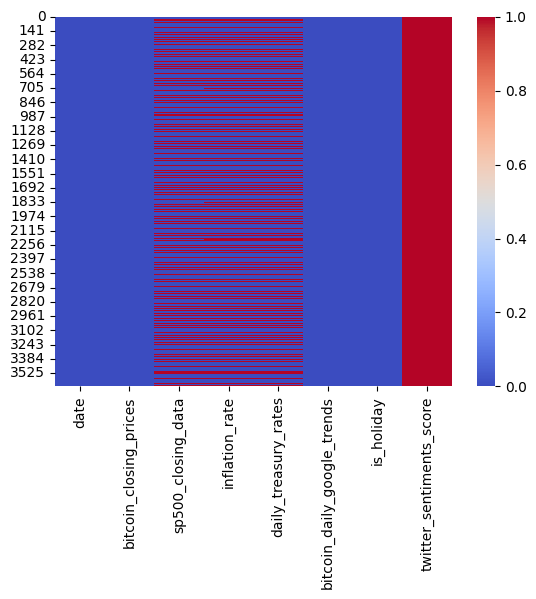

In [12]:
# heatmap of missing values
sns.heatmap(df.isnull(), cmap='coolwarm')

In [13]:
# ffilling missing values in 'sp500_closing_data', 'inflation_rate' and 'daily_treasury_rate' columns
df['sp500_closing_data'] = df['sp500_closing_data'].fillna(method='ffill')
df['inflation_rate'] = df['inflation_rate'].fillna(method='ffill')
df['daily_treasury_rates'] = df['daily_treasury_rates'].fillna(method='ffill')

In [14]:
# bfilling missing values in 'sp500_closing_data', 'inflation_rate' and 'daily_treasury_rate' columns.
# this bfill is for date 01-Nov-2014 and 02-Nov-2014 only as days on these dates are Saturday and Sunday respectively and we have no data to ffill
df['sp500_closing_data'] = df['sp500_closing_data'].fillna(method='bfill')
df['inflation_rate'] = df['inflation_rate'].fillna(method='bfill')
df['daily_treasury_rates'] = df['daily_treasury_rates'].fillna(method='bfill')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3656 entries, 0 to 3655
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         3656 non-null   datetime64[ns]
 1   bitcoin_closing_prices       3655 non-null   float64       
 2   sp500_closing_data           3656 non-null   float64       
 3   inflation_rate               3656 non-null   float64       
 4   daily_treasury_rates         3656 non-null   float64       
 5   bitcoin_daily_google_trends  3656 non-null   int64         
 6   is_holiday                   3656 non-null   int64         
 7   twitter_sentiments_score     0 non-null      float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 228.6 KB


In [16]:
# Check for missing values
missing_values_count = df.isnull().sum()
missing_values_percent = (df.isnull().sum() / len(df)) * 100
missing_values_percent = missing_values_percent.round(2)
missing_values= pd.concat([missing_values_count, missing_values_percent], axis=1)
missing_values.columns = ['Count', 'Percentage']

print("Missing values:")
print(missing_values)

Missing values:
                             Count  Percentage
date                             0        0.00
bitcoin_closing_prices           1        0.03
sp500_closing_data               0        0.00
inflation_rate                   0        0.00
daily_treasury_rates             0        0.00
bitcoin_daily_google_trends      0        0.00
is_holiday                       0        0.00
twitter_sentiments_score      3656      100.00


In [17]:
# checking dates where null values are present
df[df['bitcoin_closing_prices'].isnull()]

,date,bitcoin_closing_prices,sp500_closing_data,inflation_rate,daily_treasury_rates,bitcoin_daily_google_trends,is_holiday,twitter_sentiments_score
3655,2024-11-03,NaN,5728.799805,2.33,4.57,52,1,NaN


## Feature Distributions

[Plot the distribution of various features and target variables. Comment on the skewness, outliers, or any other observations.]


In [18]:
df.columns

Index(['date', 'bitcoin_closing_prices', 'sp500_closing_data',
       'inflation_rate', 'daily_treasury_rates', 'bitcoin_daily_google_trends',
       'is_holiday', 'twitter_sentiments_score'],
      dtype='object')

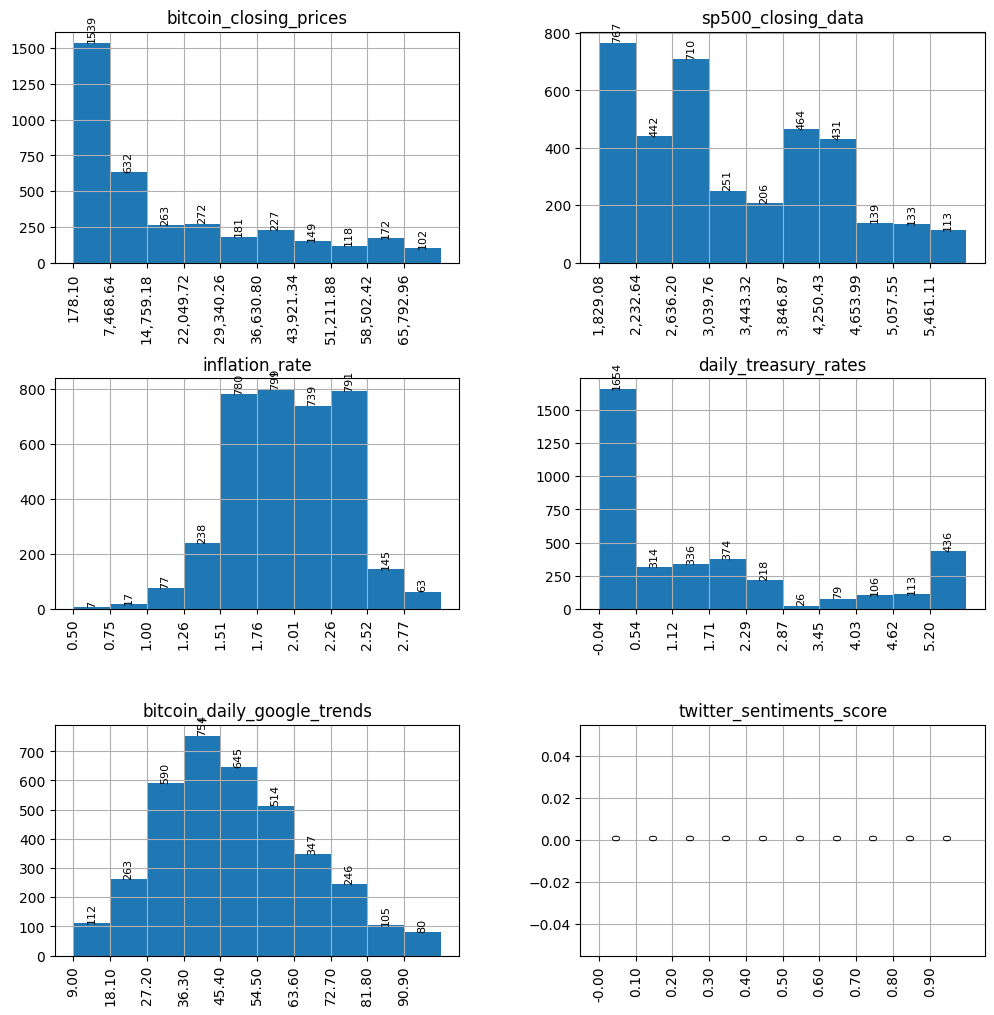

In [19]:
# Plotting histograms of all numerical features
bins=10

df[['bitcoin_closing_prices', 'sp500_closing_data', 'inflation_rate', 'daily_treasury_rates', 
    'bitcoin_daily_google_trends', 'twitter_sentiments_score']].hist(bins=bins, figsize=(12, 12))

# displaying count of values above each bar
for ax in plt.gcf().axes:
    for container in ax.containers:
        ax.bar_label(container, rotation=90, fontsize=8)
    
    # Set x-ticks for each bin (using bin edges)
    bin_edges = ax.patches[0].get_x()  # Getting the starting position of the first bin
    bin_width = ax.patches[0].get_width()  # Width of each bin
    ticks = [bin_edges + i * bin_width for i in range(bins)]  # Generate bin centers
    ax.set_xticks(ticks)  # Set ticks on x-axis
    ax.set_xticklabels([f'{tick:,.2f}' for tick in ticks], rotation=90)  # Format labels for better readability
plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Increase vertical and horizontal space
plt.grid(True)
plt.show()

## Possible Biases

[Investigate the dataset for any biases that could affect the model’s performance and fairness (e.g., class imbalance, historical biases).]


In [20]:
# Example: Checking for class imbalance in a classification problem
# sns.countplot(x='target_variable', data=df)

# Your code to investigate possible biases goes here


## Correlations

[Explore correlations between features and the target variable, as well as among features themselves.]


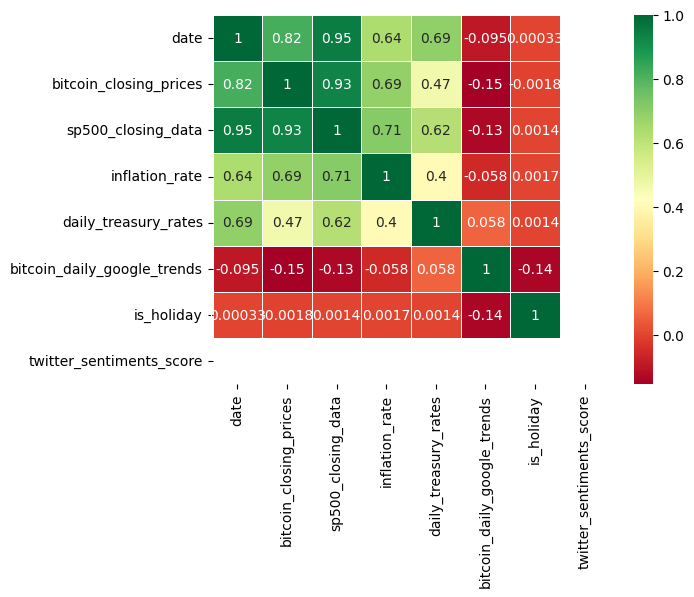

In [21]:
# Example: Plotting a heatmap to show feature correlations

corr = df.corr()
sns.heatmap(corr, cmap='RdYlGn', annot=True, linewidths=0.5)
plt.show()


In [22]:
corr.map(nf_2)

,date,bitcoin_closing_prices,sp500_closing_data,inflation_rate,daily_treasury_rates,bitcoin_daily_google_trends,is_holiday,twitter_sentiments_score
date,1.00,0.82,0.95,0.64,0.69,-0.09,0.00,nan
bitcoin_closing_prices,0.82,1.00,0.93,0.69,0.47,-0.15,-0.00,nan
sp500_closing_data,0.95,0.93,1.00,0.71,0.62,-0.13,0.00,nan
inflation_rate,0.64,0.69,0.71,1.00,0.40,-0.06,0.00,nan
daily_treasury_rates,0.69,0.47,0.62,0.40,1.00,0.06,0.00,nan
bitcoin_daily_google_trends,-0.09,-0.15,-0.13,-0.06,0.06,1.00,-0.14,nan
is_holiday,0.00,-0.00,0.00,0.00,0.00,-0.14,1.00,nan
twitter_sentiments_score,nan,nan,nan,nan,nan,nan,nan,nan


In [24]:
df.columns

Index(['date', 'bitcoin_closing_prices', 'sp500_closing_data',
       'inflation_rate', 'daily_treasury_rates', 'bitcoin_daily_google_trends',
       'is_holiday', 'twitter_sentiments_score'],
      dtype='object')

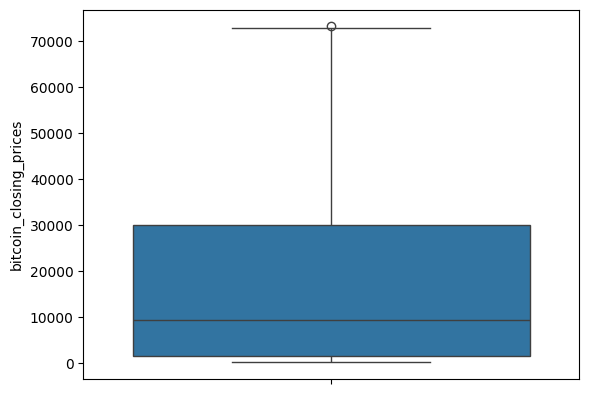

In [23]:
# Check for outliers using boxplot
sns.boxplot(data=df['bitcoin_closing_prices'])
plt.xticks(rotation=90)
plt.show()

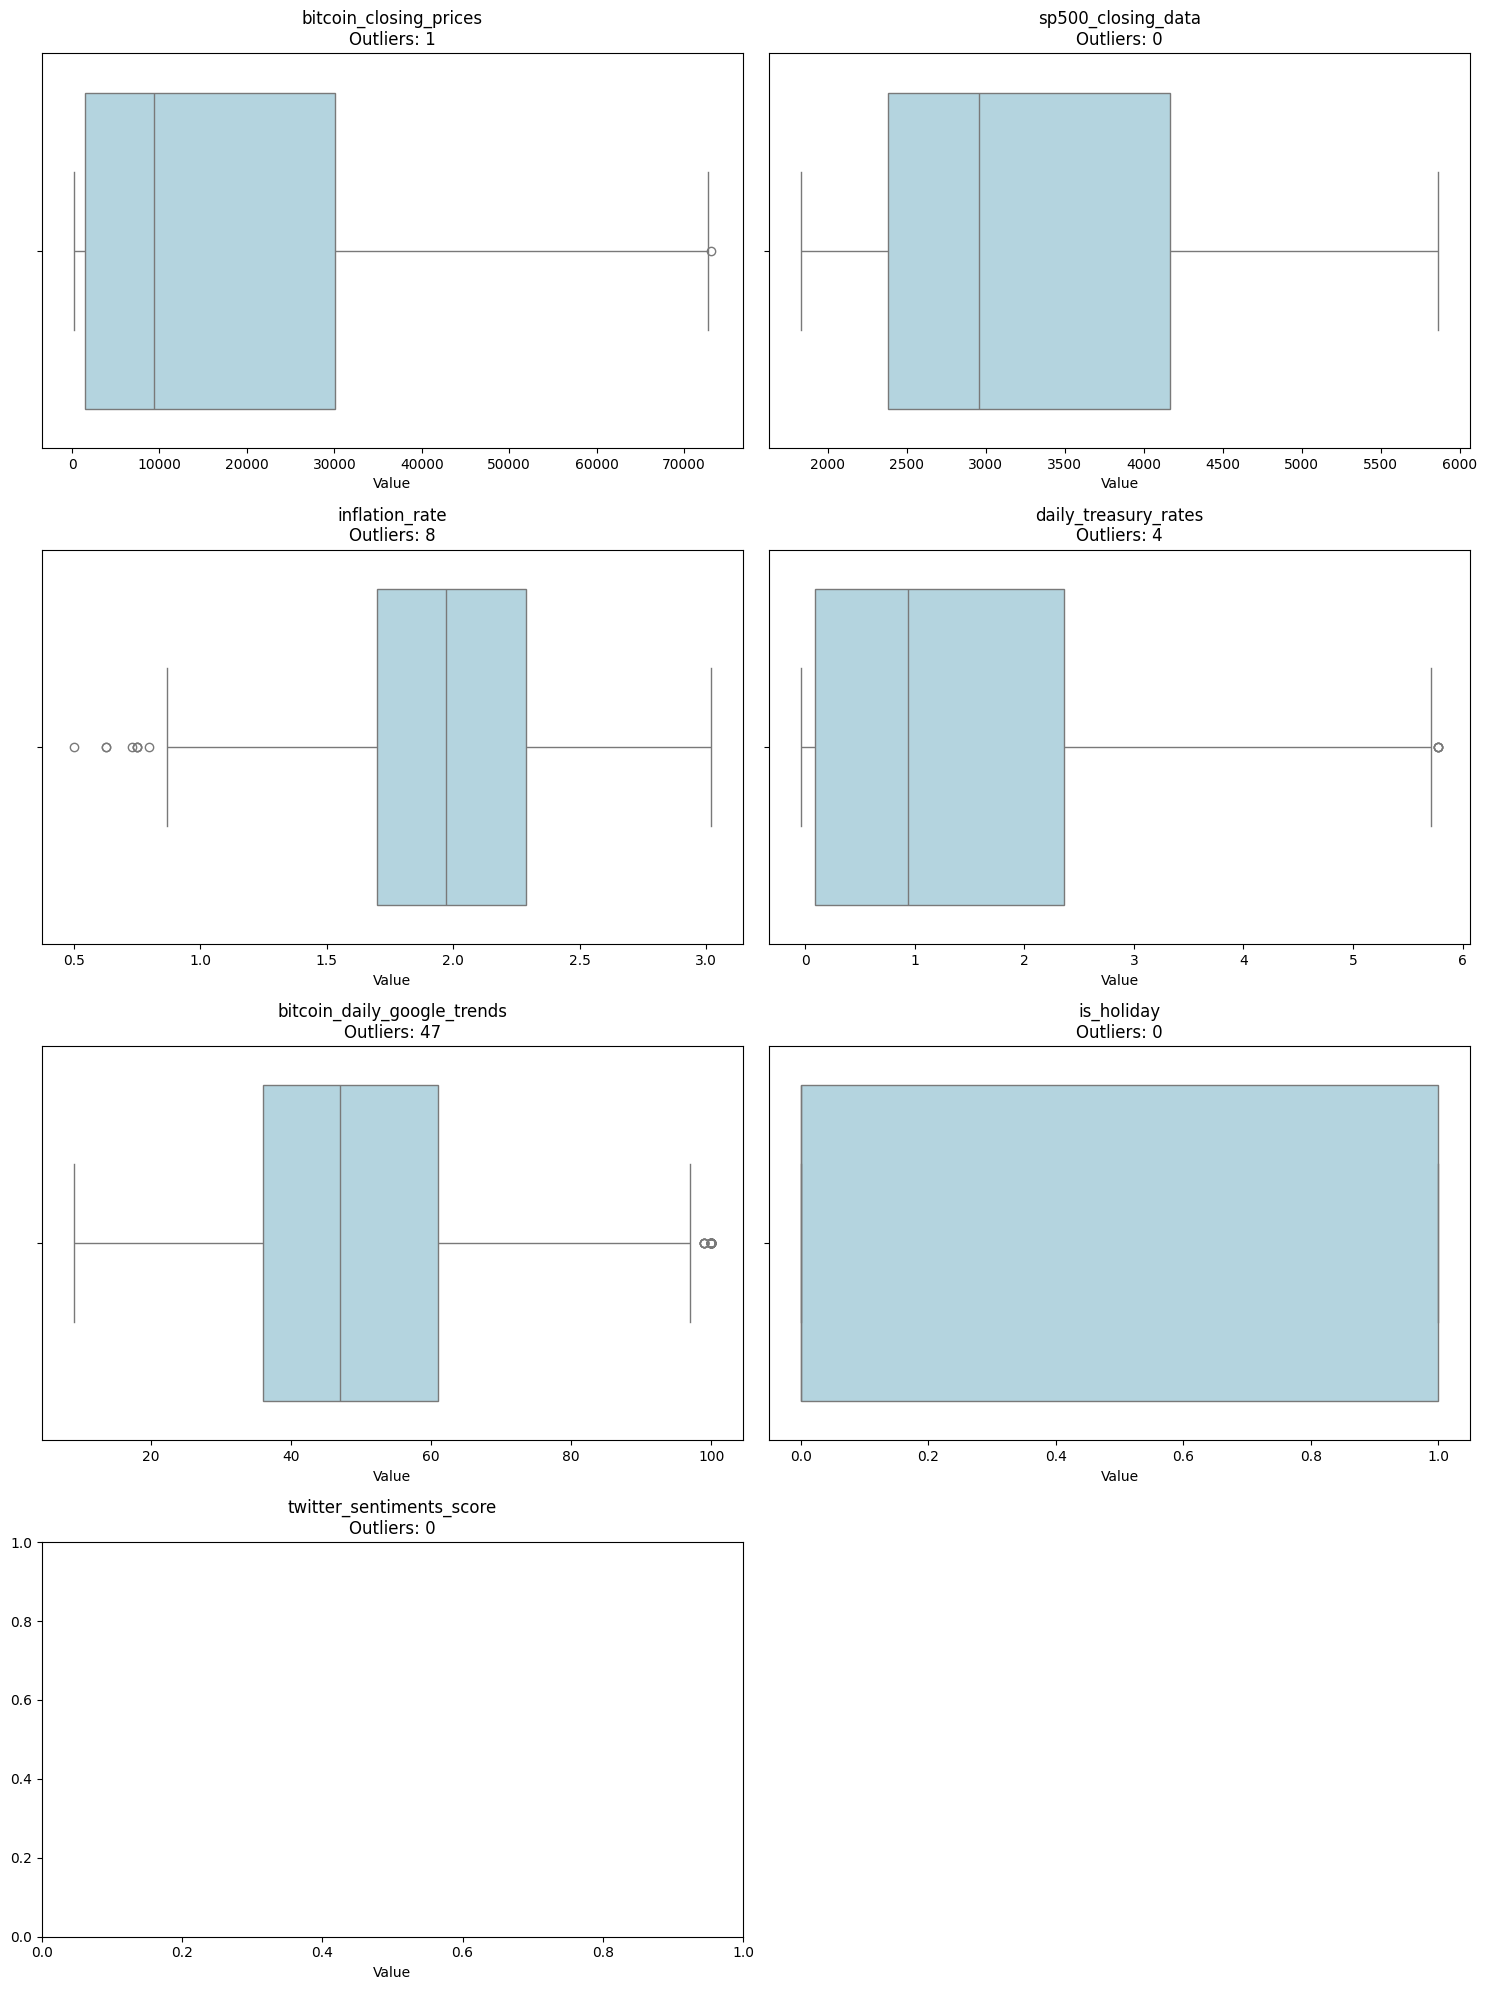

In [32]:
# Function to detect outliers using the IQR method
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((data < lower_bound) | (data > upper_bound))

# Filter numeric columns only
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Set up the plot grid (4x2 layout)
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

# Generate boxplots for each numeric column
for i, col in enumerate(numeric_columns):
    ax = axes[i]
    valid_data = df[col].dropna()  # Drop missing values
    sns.boxplot(x=valid_data, ax=ax, color='lightblue')  # Pass clean data

    # Detect and count outliers
    outliers = detect_outliers_iqr(valid_data)
    num_outliers = outliers.sum()

    # Annotate the plot with the number of outliers
    ax.set_title(f"{col}\nOutliers: {num_outliers}", fontsize=12)
    ax.set_xlabel('Value')
    ax.set_ylabel('')

# Hide unused subplots if columns < 8
for j in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()